# Pré-processamento e anotação de dados

Pré-processamentos:
- Remoção do primeiro e último terremotos (terremotos incompletos)
- Separação do dataset por terremotos (15 no total)
- Balanceamento dos folds em relação aos periodos de duração dos terremotos

## Conectando ao Google Drive

In [2]:
## Conectando o notebook com o Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Testando se o notebook acessa o Drive corretamente
!ls 'drive/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'My Drive'  'Shared drives'


In [3]:
#  Mover a pasta compartilhada para algum lugar em seu proprio drive, 
#  para conseguir acessar um atalho para o diretorio a partir daqui.

## Configurar essa variavel de ambiente (path_dados) para cada pessoa
## Meu caminho no drive (alexandre)
%env drv=drive/My Drive
%env proj=Aulas/2019_2/ie301-projeto/projeto

!ls "$drv/$proj/dados/"
!echo "-------"
!ls .

env: drv=drive/My Drive
env: proj=Aulas/2019_2/ie301-projeto/projeto
dataset-preprocessado.pkl  old			    train_downsample_100.csv
features.pkl		   sample_submission.csv    x_segments.pkl
new_dataset_kfold.pkl	   test_downsampled
new_features_kfold.pkl	   test_downsampled.tar.gz
-------
drive  sample_data


## Importando bibliotecas

In [1]:
## Basic imports
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

## Utils
import timeit
import time
from tqdm import tqdm
import pickle


Populating the interactive namespace from numpy and matplotlib


## Pre-processamento

In [0]:
## Carreando base de treino (downsampled)
!cp "$drv/$proj/dados/train_downsample_100.csv" .
df_orig = pd.read_csv('train_downsample_100.csv')

## Indices das bordas de subida e valores de amplitude
idx = df_orig.loc[(df_orig['time_to_failure'].shift(1) < df_orig['time_to_failure']), :].index
eq_periods = df_orig.loc[(df_orig['time_to_failure'].shift(1) < df_orig['time_to_failure']), 'time_to_failure'].values

## Anotando o periodo de cada terremoto
grupo = 0
for i in range(len(idx)-1):
    df_orig.loc[idx[i]:idx[i+1], 'EQ_PERIOD'] = eq_periods[i]
    df_orig.loc[idx[i]:idx[i+1], 'EQ_NUM'] = grupo
    grupo = grupo + 1

In [5]:
## Removendo o primeiro e o ultimo terremoto
eq_periods = np.delete(eq_periods, -1)
eq_threshold = np.median(eq_periods)    

# # anotação para classificacao
# for i in range(len(idx)-1):
#     df_orig.loc[idx[i]:idx[i+1], 'EQ_CLASS'] = float(eq_periods[i] > eq_threshold) # 0-low; 1-high

drop_eq00 = np.arange(0,idx[0],1)
drop_eq16 = np.arange(idx[-1], len(df_orig), 1)

df_orig = df_orig.drop(drop_eq00)
df_orig = df_orig.drop(drop_eq16)

df_orig = df_orig.reset_index()
df_orig = df_orig.drop(columns=['index'])
df_orig.head()

,acoustic_data,time_to_failure,EQ_PERIOD,EQ_NUM
0,3,11.5408,11.5408,0.0
1,9,11.5408,11.5408,0.0
2,3,11.5408,11.5408,0.0
3,6,11.5408,11.5408,0.0
4,6,11.5408,11.5408,0.0


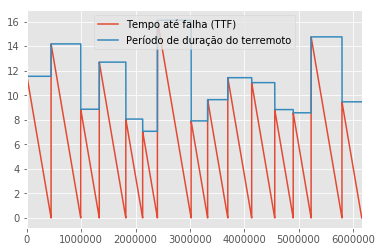

In [15]:
# ax = 
with plt.style.context('ggplot'):
    df_orig['time_to_failure'].plot(label='Tempo até falha (TTF)')
    df_orig['EQ_PERIOD'].plot(label='Período de duração do terremoto')
    # df_orig['EQ_NUM'].plot(label='Número do terremoto')
    plt.legend()
    savefig('anotacao-terremotos.eps', format='eps', dpi=400)
    savefig('anotacao-terremotos.png', format='png', dpi=400)

!cp anotacao-terremotos* "$drv/$proj/imagens/"

### Definindo os conjuntos do k-fold
- 3-fold (k=3)
- Cada fold contém 5 terremotos, um de cada grupo (1-5)
- Escolha de maneira aleatória

In [0]:
## Ordenando pelo periodo de duracao
eq_sorted_idx = np.argsort(eq_periods)
eq_sorted = np.sort(eq_periods)

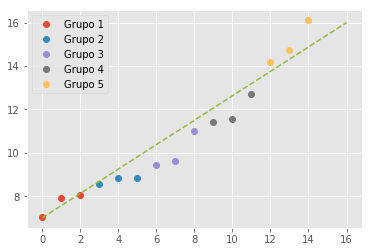

In [14]:
## Agrupando em 5 niveis
with plt.style.context('ggplot'):
    for i in range(5):
        pos = i*3
        plt.plot(np.arange(pos,pos+3), eq_sorted[pos:pos+3], 'o', label='Grupo {:d}'.format(i+1))
    plt.plot([0,16], [7,16], '--')
    plt.legend()
    savefig('grupos-terremotos.eps', format='eps', dpi=400)
    savefig('grupos-terremotos.png', format='png', dpi=400)
!cp grupos-terremotos.* "$drv/$proj/imagens/"

In [18]:
## Arrays dos 5 grupos
fold_eqs = np.copy(eq_sorted_idx.reshape([5,3]))
for g in range(5):
    print('Periodos dos terremotos do grupo', g+1, ':', eq_periods[fold_eqs[g].ravel()])

Periodos dos terremotos do grupo 1 : [7.05899992 7.90559991 8.05549991]
Periodos dos terremotos do grupo 2 : [8.56599993 8.82809993 8.85669994]
Periodos dos terremotos do grupo 3 : [ 9.45949996  9.63709999 11.02419999]
Periodos dos terremotos do grupo 4 : [11.42639995 11.54079996 12.69399994]
Periodos dos terremotos do grupo 5 : [14.18059997 14.75179992 16.10739999]


In [23]:
## Sorteando os 3 folds
for i in range(5): np.random.shuffle(fold_eqs[i])
fold_eqs = fold_eqs.T

## valores utilizados:
# k= 0 : [ 5 11  8  0  1]
# k= 1 : [ 7 12 14  9  6]
# k= 2 : [ 4  2 10  3 13]
# fold_eqs = np.array([[5, 11, 8, 0, 1],
#                      [7, 12, 14, 9, 6],
#                      [4, 2, 10, 3, 13]])

for k in range(3):
    print('k=', k, ':', fold_eqs[k])

k= 0 : [ 5 11  8  0  1]
k= 1 : [ 7 12 14  9  6]
k= 2 : [ 4  2 10  3 13]


In [24]:
## Exibindo os resultados das 3 folds
for k in range(3):
    print('Periodos dos terremotos do fold', k+1, ':', eq_periods[fold_eqs[k]])

Periodos dos terremotos do fold 1 : [ 7.05899992  8.82809993  9.63709999 11.54079996 14.18059997]
Periodos dos terremotos do fold 2 : [ 7.90559991  8.56599993  9.45949996 11.42639995 16.10739999]
Periodos dos terremotos do fold 3 : [ 8.05549991  8.85669994 11.02419999 12.69399994 14.75179992]


- Periodos dos terremotos do fold 1 : 
        [ 7.05899992  8.82809993  9.63709999 11.54079996 14.18059997]
- Periodos dos terremotos do fold 2 : 
        [ 7.90559991  8.56599993  9.45949996 11.42639995 16.10739999]
- Periodos dos terremotos do fold 3 : 
        [ 8.05549991  8.85669994 11.02419999 12.69399994 14.75179992]

### Gerando o novo dataset dividido em folds

In [25]:
## Passos de 300 em 300 (overlap de 80%)
segments_by_eq = []
ttfs_by_eq = []

for eq in tqdm(range(15)): # 15 terremotos
    df = df_orig[df_orig['EQ_NUM']==eq]
    base_index = df.index[0]
    max_index = int((df.shape[0]-1500) / 300)
    x_eq = np.zeros([max_index, 1500])
    y_eq = np.zeros(max_index)
    eqp_eq = np.zeros(max_index)
    
    for line in range(max_index):
        index = base_index + line*300
        x_eq[line, :] = df.loc[index:index + 1499,
                                'acoustic_data'].values
        y_eq[line] = df['time_to_failure'][index+1499]
        # eqp_eq[line] = df['EQ_PERIOD'][index+1499]
    segments_by_eq.append(x_eq)
    ttfs_by_eq.append(y_eq)

100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


In [0]:
segments_by_fold = []
ttfs_by_fold = []
for k in range(3):
    segments_by_fold.append(
        np.concatenate((np.array(segments_by_eq)[fold_eqs[k]]), axis=0)
    )
    ttfs_by_fold.append(
        np.concatenate((np.array(ttfs_by_eq)[fold_eqs[k]]), axis=0)
    )

### Verificando conteúdo dos 3 folds (sanity check)

In [27]:
total = 0
for k in range(3):
    linhas = segments_by_fold[k].shape[0]
    total = total + linhas
    print('Linhas no fold k=', k+1, ':', linhas)
print('Total:', total)

Linhas no fold k= 1 : 6547
Linhas no fold k= 2 : 6833
Linhas no fold k= 3 : 7079
Total: 20459


In [28]:
total = 0
for n in range(15):
    linhas = segments_by_eq[n].shape[0]
    total = total + linhas
    print('Linhas no terremoto n=', n+1, ':', linhas)
print('Total:', total)

Linhas no terremoto n= 1 : 1475
Linhas no terremoto n= 2 : 1814
Linhas no terremoto n= 3 : 1131
Linhas no terremoto n= 4 : 1623
Linhas no terremoto n= 5 : 1028
Linhas no terremoto n= 6 : 900
Linhas no terremoto n= 7 : 2061
Linhas no terremoto n= 8 : 1009
Linhas no terremoto n= 9 : 1231
Linhas no terremoto n= 10 : 1461
Linhas no terremoto n= 11 : 1409
Linhas no terremoto n= 12 : 1127
Linhas no terremoto n= 13 : 1094
Linhas no terremoto n= 14 : 1888
Linhas no terremoto n= 15 : 1208
Total: 20459


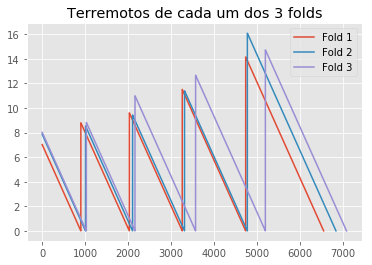

In [33]:
## sanity check
with plt.style.context('ggplot'):
    for i in range(3):
        plt.plot(ttfs_by_fold[i], label='Fold {:d}'.format(i+1))
        plt.legend()
    plt.title('Terremotos de cada um dos 3 folds')
    savefig('terremotos-3fold.eps', format='eps', dpi=400)
    savefig('terremotos-3fold.png', format='png', dpi=400)
!cp terremotos-3fold.* "$drv/$proj/imagens/"

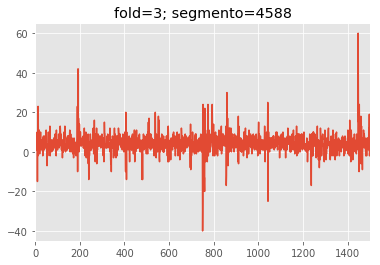

In [0]:
k = np.random.randint(3)
fold = segments_by_fold[k]
seg = np.random.randint(fold.shape[0])
with plt.style.context('ggplot'):
    plt.plot(fold[seg]);
    plt.title('fold={:d}; segmento={:d}'.format(k+1, seg+1));
    plt.xlim([0,1500])

## Gravando resultados

In [0]:
novo_dataset = {
    'segments_by_eq': segments_by_eq,
    'ttfs_by_eq': ttfs_by_eq,
    'segments_by_fold': segments_by_fold,
    'ttfs_by_fold': ttfs_by_fold,
}

with open('new_dataset_kfold.pkl', 'wb') as f:
    pickle.dump(novo_dataset, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

!cp new_dataset_kfold.pkl "$drv/$proj/dados/"